In [1]:
import pandas as pd
import urllib
from urllib.request import urlopen
import json
import datetime
import numpy as np



In [2]:
def extract_coinmarketcap(coin, coin_col=False):

        """Retrieve basic historical information for a specific cryptocurrency from coinmarketcap.com

        

        Parameters

        ----------

        coin : the name of the cryptocurrency (e.g. 'bitcoin', 'ethereum', 'dentacoin')

        coin_col : whether to include the coin name as a column

            (default is False i.e. the column is not included)

            

        Returns

        -------

        pandas Dataframe

        """

        try:
            #print(self)
            #print(coin)
            #print(coin_col)
            from_date = "2017-04-27"
            to_date = "2018-04-27"
            output = pd.read_html("https://coinmarketcap.com/currencies/{}/historical-data/?start={}&end={}".format(
                coin, from_date.replace("-", ""), to_date.replace("-", "")))[0]
           # output= pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20170408&end=20180428")
                                 
        except Exception as e:

            return pd.DataFrame({"error":e}, index=[0])

        output = output.assign(Date=pd.to_datetime(output['Date']))

        for col in output.columns:

            if output[col].dtype == np.dtype('O'):

                output.loc[output[col]=="-",col]=0

                output[col] = output[col].astype('int64')

        output.columns = [col.lower() for col in output.columns]

        if coin_col:

            output['coin'] = coin

        return output

In [12]:
def get_google_trends( kw_list, trdays=250, overlap=100, 

                          cat=0, geo='', tz=360, gprop='', hl='en-US',

                          sleeptime=1, isPartial_col=False, 

                          from_start=False, scale_cols=True):

        """Retrieve daily google trends data for a list of search terms

        

        Parameters

        ----------

        kw_list : list of search terms (max 5)- see pyTrends for more details

        trdays : the number of days to pull data for in a search

            (the max is around 270, though the website seems to indicate 90)

        overlap : the number of overlapped days when stitching two searches together

        cat : category to narrow results - see pyTrends for more details

        geo : two letter country abbreviation (e.g 'US', 'UK') 

            default is '', which returns global results - see pyTrends for more details

        tz : timezone offset

            (default is 360, which corresponds to US CST - see pyTrends for more details)

        grop : filter results to specific google property

            available options are 'images', 'news', 'youtube' or 'froogle'

            default is '', which refers to web searches - see pyTrends for more details

        hl : language (e.g. 'en-US' (default), 'es') - see pyTrends for more details

        sleeptime : when stiching multiple searches, this sets the period between each

        isPartial_col : remove the isPartial column 

            (default is True i.e. column is removed)

        from_start : when stitching multiple results, this determines whether searches

            are combined going forward or backwards in time

            (default is False, meaning searches are stitched with the most recent first)

        scale_cols : google trend searches traditionally returns scores between 0 and 100

            stitching could produce values greater than 100

            by setting this to True (default), the values will range between 0 and 100

        

        Returns

        -------

        pandas Dataframe

        

        Notes

        -----

        This method is essentially a highly restricted wrapper for the pytrends package

        Any issues/questions related to its use would probably be more likely resolved

        by consulting the pytrends github page

        https://github.com/GeneralMills/pytrends

        """

        

        if len(kw_list)>5 or len(kw_list)==0:

            raise ValueError("The keyword list can contain at most 5 words")

        if trdays>270:

            raise ValueError("trdays must not exceed 270")

        if overlap>=trdays:

            raise ValueError("Overlap can't exceed search days")

        from_date="2017-04-27"
        to_date="2018-04-27"
        
        stich_overlap = trdays - overlap

        from_date = datetime.datetime.strptime(from_date, '%Y-%m-%d')

        to_date = datetime.datetime.strptime(to_date, '%Y-%m-%d')

        n_days = (to_date - from_date).days

        # launch pytrends request

        _pytrends = TrendReq(hl=hl, tz=tz)

        # get the dates for each search

        if n_days <= trdays:

            trend_dates = [' '.join([from_date, to_date])]

        else:

            trend_dates = ['{} {}'.format(

            (to_date - datetime.timedelta(i+trdays)).strftime("%Y-%m-%d"),

            (to_date - datetime.timedelta(i)).strftime("%Y-%m-%d")) 

                           for i in range(0,n_days-trdays+stich_overlap,

                                          stich_overlap)]

        if from_start:

            trend_dates = trend_dates[::-1]

        try:

            _pytrends.build_payload(kw_list, cat=cat, timeframe=trend_dates[0], 

                                   geo=geo, gprop=gprop)

        except Exception as e:

            return pd.DataFrame({"error":e}, index=[0])

        output = _pytrends.interest_over_time().reset_index()

        if len(output)==0:

            return pd.DataFrame({"error":'search term returned no results (insufficient data)'}, index=[0])

        for date in trend_dates[1:]:

            time.sleep(sleeptime)

            try:

                _pytrends.build_payload(kw_list, cat=cat, timeframe=date, 

                                         geo=geo, gprop=gprop)

            except Exception as e:

                return pd.DataFrame({"error":e}, index=[0])

            temp_trend = _pytrends.interest_over_time().reset_index()

            temp_trend = temp_trend.merge(output, on="date", how="left")

            # it's ugly but we'll exploit the common column names

            # and then rename the underscore containing column names

            for kw in kw_list:

                norm_factor = np.ma.masked_invalid(temp_trend[kw+'_y']/temp_trend[kw+'_x']).mean()

                temp_trend[kw] = temp_trend[kw+'_x'] * norm_factor

            temp_trend =  temp_trend[temp_trend.isnull().any(axis=1)]

            temp_trend['isPartial'] = temp_trend['isPartial_x']

            output = pd.concat([output, temp_trend[['date', 'isPartial'] + kw_list]], axis=0)

        

        # reorder columns in alphabetical order

        output = output[['date', 'isPartial']+kw_list]

        

        if not isPartial_col:

            output = output.drop('isPartial', axis=1)

        output = output[output['date']>=from_date]

        if scale_cols:

            # the values in each column are relative to other columns

            # so we need to get the maximum value across the search columns

            max_val = float(output[kw_list].values.max())

            for col in kw_list:

                output[col] = 100.0*output[col]/max_val

        output = output.sort_values('date', ascending=True).reset_index(drop=True)

        return output

In [13]:
import time

btc_google = get_google_trends(kw_list=['bitcoin']).merge(
    extract_coinmarketcap('bitcoin')[['date','close']], on='date', how='inner')

eth_google = get_google_trends(kw_list=['ethereum']).merge(
    extract_coinmarketcap('ethereum')[['date','close']], on='date', how='inner')

verge_google = get_google_trends(kw_list=['verge']).merge(
    extract_coinmarketcap('verge')[['date','close']], on='date', how='inner')

In [14]:
btc_google.head(5)

,date,bitcoin,close
0,2017-04-27,3.343825,1317.73
1,2017-04-28,3.343825,1316.48
2,2017-04-29,2.972289,1321.79
3,2017-04-30,2.972289,1347.89
4,2017-05-01,3.715361,1421.60


In [15]:
for df,search_term in zip([btc_google, eth_google, verge_google], 
                          ['bitcoin', 'ethereum', 'verge']):
    df[[search_term,'close']] = (
        df[[search_term, 'close']]-df[[search_term, 'close']].min())/(
        df[[search_term, 'close']].max()-df[[search_term, 'close']].min())

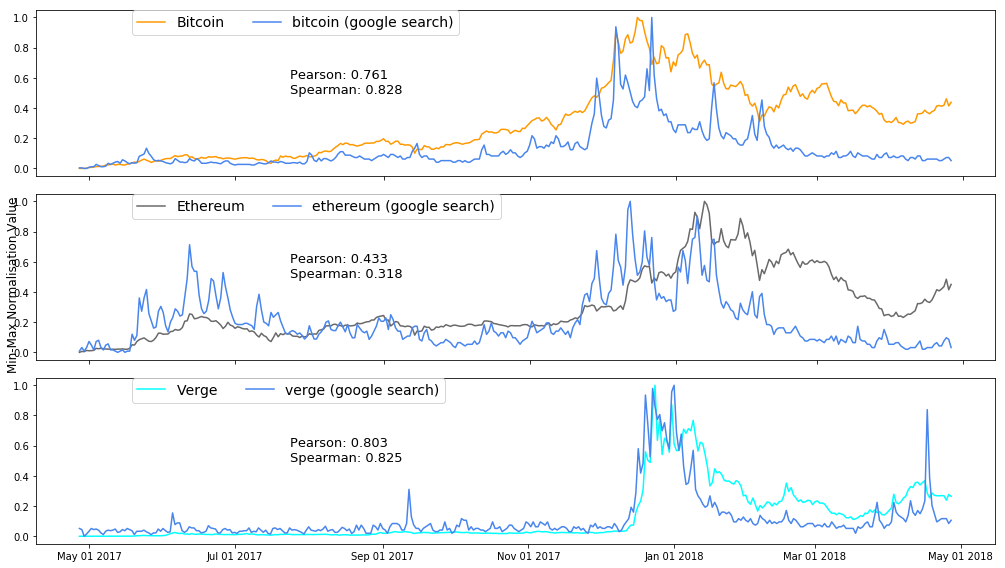

In [25]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 8))

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017,2019)])

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') for i in range(1,13,2) for j in range(2017,2019)])
for ax,df,search_term, coin, pcol, gcol in zip([ax1, ax2, ax3],[btc_google, eth_google, verge_google], 
                                               ['bitcoin', 'ethereum', 'verge'],
                                               ['Bitcoin', 'Ethereum', 'Verge'], 
                                               ['#FF9900', '#696969', '#00FFFF'],
                                               ['#4885ed', '#4885ed', '#4885ed']):
    ax.plot(df['date'].astype(datetime.datetime),
             df['close'], label=coin, color=pcol)
    ax.plot(df['date'].astype(datetime.datetime),
             df[search_term], label="{} (google search)".format(search_term), color=gcol)
    ax.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=4, prop={'size': 14})
    ax.text(x=mdates.date2num(datetime.date(2017, 7, 24)), y=0.5, fontsize=13,
         s='Pearson: {}\nSpearman: {}'.format(
        round(df['close'].corr(df[search_term],method='pearson'),3), 
        round(df['close'].corr(df[search_term],method='spearman'),3)))
fig.text(0.005, 0.5, 'Min-Max Normalisation Value', va='center', rotation='vertical',fontsize=12)
plt.tight_layout()
plt.show()

The above graph shows that there's a strong correlation between google searches and coin prices. 